# lifelines ukko AML model

Notebook to develop the ukko model with AML data

Kernals to use:

- Carbon X1:  pytorch
- HUS Dell:  py312_pytorch
- CSC: 
- ecare4meb2 ML: 

In [1]:
import torch
import torch.nn as nn
import math
import ukko 
import importlib
# For preprocessing
#print("Loading sklearn")
#from sklearn.preprocessing import StandardScaler
#from sklearn_pandas import DataFrameMapper 
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# lifelines
import lifelines
from lifelines import CoxPHFitter

# torchsurv
#from torchsurv.loss.cox import neg_partial_log_likelihood
#from torchsurv.loss.weibull import neg_log_likelihood, log_hazard, survival_function
#from torchsurv.metrics.brier_score import BrierScore
#from torchsurv.metrics.cindex import ConcordanceIndex
#from torchsurv.metrics.auc import Auc
#from torchsurv.stats.kaplan_meier import KaplanMeierEstimator

print("Libraries loaded")

Libraries loaded


For interactive plots execute:

In jupyter notebook:

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In VSCode, JupyterLab:

- you need to have `ipykernel` installed, eg. from conda-forge 

In [3]:
#conda install conda-forge::ipykernal 

# Import and configure interactive plotting
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Enable interactive mode
%matplotlib widget

# Test widget functionality
def test_interactive():
    slider = widgets.FloatSlider(
        value=0.4,
        min=0.0,
        max=1.0,
        step=0.01,
        description='Test:',
        continuous_update=False
    )
    display(slider)
    return "Widget test complete"

test_interactive()

FloatSlider(value=0.4, continuous_update=False, description='Test:', max=1.0, step=0.01)

'Widget test complete'

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt

In [11]:
%matplotlib inline

In [3]:
%matplotlib --list

Available matplotlib backends: ['agg', 'auto', 'cairo', 'gtk3', 'gtk3agg', 'gtk3cairo', 'gtk4', 'gtk4agg', 'gtk4cairo', 'inline', 'ipympl', 'macosx', 'module://ipympl.backend_nbagg', 'nbagg', 'notebook', 'osx', 'pdf', 'pgf', 'ps', 'qt', 'qt5', 'qt5agg', 'qt5cairo', 'qt6', 'qtagg', 'qtcairo', 'svg', 'template', 'tk', 'tkagg', 'tkcairo', 'webagg', 'widget', 'wx', 'wx', 'wxagg', 'wxcairo']


## Load data

In [2]:
#Load tidy data
print("Loading tidy data")
df_xy = pd.read_csv("data/df_xy_synth_v1.csv")

# create train, validation and test datasets: IMPUTE nan: -1
df_train = df_xy.fillna(-1)
df_test = df_train.sample(n=200, random_state=42)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(n=200, random_state=42)
df_train = df_train.drop(df_val.index)

print(f"Train: {df_train.shape}")
print(f"Val  : {df_val.shape}")
print(f"Test : {df_test.shape}")


Loading tidy data
Train: (600, 273)
Val  : (200, 273)
Test : (200, 273)


In [3]:
df_train.head(5)

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,0,1101.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0.850735,-1.0,...,35.267531,21.842999,26.972079,6.470798,25.946376,35.851646,-1.000000,-1.000000,-1.000000,-1.000000
1,1,532.0,1,2.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,17.644103,5.856022,33.222468,30.042670,10.961655,16.626338,14.611647,6.030153,27.483864,-1.000000
3,3,90.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,19.108278,-1.000000,10.593051,-1.000000,2.842802,11.054564,-1.000000,23.594939,27.795295,-1.000000
4,4,1885.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,...,27.111444,8.762440,22.310250,25.011994,18.616336,8.396031,11.796703,1.913356,0.251289,-1.000000
5,5,873.0,1,-1.0,-1.0,-1.0,-1.0,-1.0,0.462423,-1.0,...,105.344265,-1.000000,78.984976,157.818442,113.174862,80.451631,85.334296,-1.000000,107.225559,56.915933


## Set-up for lifelines

In [3]:
# Define plotting function based on thresholds
# Note feature col can be the predicted risk score from the model
from matplotlib import pyplot as plt

def plot_km_by_thresholds(df, thresholds, duration_col='OSS_days', event_col='OSS_status', feature_col='OSS_status'):
    kmf = lifelines.KaplanMeierFitter()
    plt.figure()

    th_before = -np.inf
    for th in thresholds:
        if th < df[feature_col].min(): 
            print(f"Skipping threshold {th} below min {df[feature_col].min()}")
            continue
        mask = (df[feature_col] <= th) & (df[feature_col] > th_before)
        kmf.fit(durations=df[mask][duration_col], event_observed=df[mask][event_col], 
                label=f"{feature_col} <= {th:.2f} (n={mask.sum()})")
        kmf.plot_survival_function()
        th_before = th

    plt.title(f"Kaplan-Meier Survival Curves by {feature_col} Thresholds")

    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    #plt.show()
    return(plt)

# Define plotting function based on quantiles
# Note feature col can be the predicted risk score from the model
def plot_km_by_quantiles(df, feature_col,duration_col='OSS_days', event_col='OSS_status', quantiles=[0.25, 0.5, 0.75]):
    kmf = lifelines.KaplanMeierFitter()
    quantile_values = df[feature_col].quantile(quantiles).values
    plt.figure()
    
    #for qv in quantile_values:
    #    mask = df[feature_col] <= qv
    #    kmf.fit(durations=df[mask][duration_col], event_observed=df[mask][event_col], label=f"{feature_col} <= {qv:.2f}")
    #    kmf.plot_survival_function()
    plot_km_by_thresholds(df, thresholds=quantile_values, duration_col=duration_col,  event_col=event_col, feature_col=feature_col)
    
    plt.title(f"Kaplan-Meier Survival Curves by {feature_col} Quantiles")
    
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.legend()
    #plt.show()
    return(quantile_values)

def plot_km_model(model, df=df_train, duration_col='OSS_days', event_col='OSS_status'):
    risk_scores = model.predict_partial_hazard(df)
    df_with_risk = df.copy()
    df_with_risk[f'{model.__dict__["_class_name"]}_risk_score'] = risk_scores.values
    quantile_values = plot_km_by_quantiles(df_with_risk, f'{model.__dict__["_class_name"]}_risk_score', duration_col, event_col, )
    return(df_with_risk, quantile_values)



In [4]:
# Data:
ll_df_train = df_train.drop(columns=['person_id']).copy()
ll_df_val = df_val.drop(columns=['person_id']).copy()
ll_df_test = df_test.drop(columns=['person_id']).copy()

# Model
cph = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.)

# Fitting
cph.fit(ll_df_train, duration_col='OSS_days', event_col='OSS_status')
#cph.print_summary()
print(cph.concordance_index_)


0.6350161818165335


In [5]:
# Model
cph2 = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=0.)

# Fitting
cph2.fit(ll_df_train, duration_col='OSS_days', event_col='OSS_status')
print(cph2.concordance_index_)


0.8045218431859594


In [6]:

# Predictions
cph.predict_survival_function(ll_df_test)
ph = cph.predict_log_partial_hazard(ll_df_test)
print('Condordance Indexes:')
print(f"Train: {cph.concordance_index_}")
print(f"Val:   {cph.score(ll_df_val, scoring_method='concordance_index')}")
print(f"Test:  {cph.score(ll_df_test, scoring_method='concordance_index')}") 
#print(ph)

Condordance Indexes:
Train: 0.6350161818165335
Val:   0.6034061277705346
Test:  0.6046800212728239


<module 'matplotlib.pyplot' from 'c:\\Users\\HUS72904793\\Anaconda3\\envs\\py312_torch\\Lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 640x480 with 0 Axes>

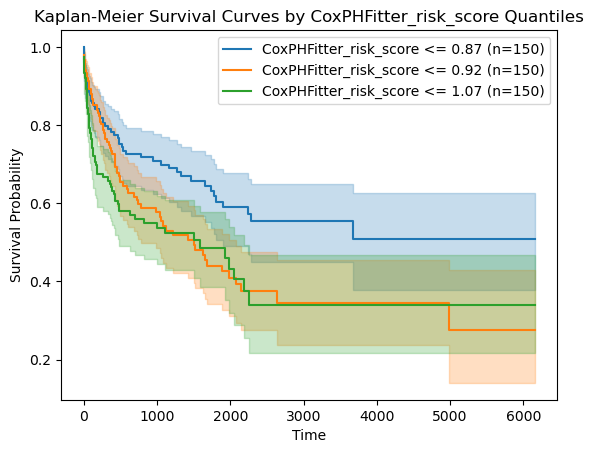

<Figure size 640x480 with 0 Axes>

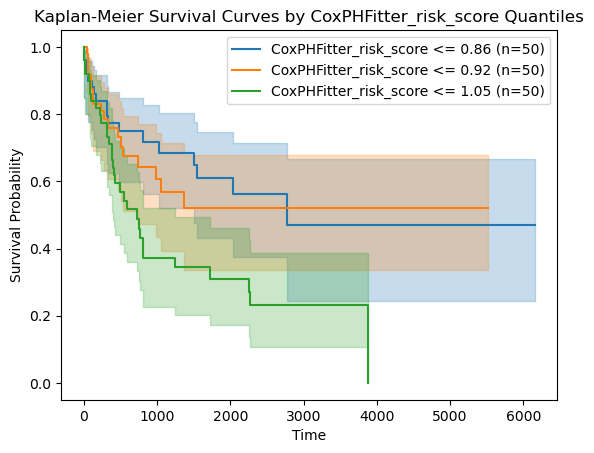

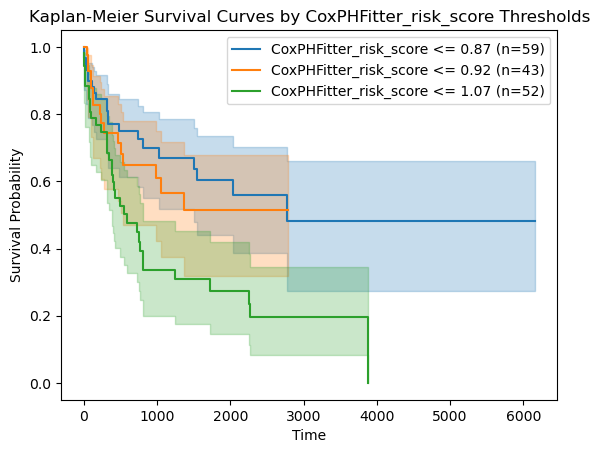

In [10]:
df_train_with_risk, threshholds_train = plot_km_model(cph, df=df_train)
df_test_with_risk, threshholds_test = plot_km_model(cph, df=df_test)
plot_km_by_thresholds(df=df_test_with_risk,
                      thresholds=threshholds_train, 
                      feature_col=f'{cph.__dict__["_class_name"]}_risk_score')

In [7]:
# Predictions
cph2.predict_survival_function(ll_df_test)
print('Condordance Indexes:')
print(f"Train: {cph2.concordance_index_}")
print(f"Val:   {cph2.score(ll_df_val, scoring_method='concordance_index')}")
print(f"Test:  {cph2.score(ll_df_test, scoring_method='concordance_index')}") 

Condordance Indexes:
Train: 0.8045218431859594
Val:   0.5972131681877445
Test:  0.5709980499911363


<Axes: >

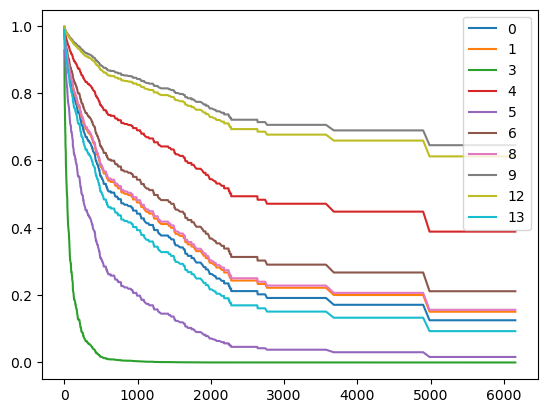

In [8]:
from lifelines.calibration import survival_probability_calibration
prob_train = cph2.predict_survival_function(ll_df_train)

prob_train.iloc[:,:10].plot()

ICI =  0.25769218901889485
E50 =  0.23685876300410796


c:\Users\HUS72904793\Anaconda3\envs\py312_torch\Lib\site-packages\lifelines\calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 1000 mortality'}, xlabel='Predicted probability of \nt ≤ 1000 mortality', ylabel='Observed probability of \nt ≤ 1000 mortality'>,
 np.float64(0.25769218901889485),
 np.float64(0.23685876300410796))

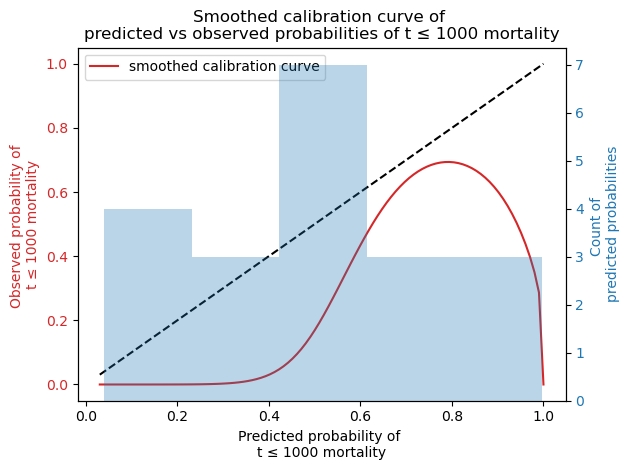

In [9]:
survival_probability_calibration(cph2, df_train.iloc[:20,:], t0=1000)


## Set up for torchsurv

In [11]:
# Detect available accelerator; Downgrade batch size if only CPU available
if any([torch.cuda.is_available(), torch.backends.mps.is_available()]):
    print("CUDA-enabled GPU/TPU is available.")
    BATCH_SIZE = 128  # batch size for training
else:
    print("No CUDA-enabled GPU found, using CPU.")
    BATCH_SIZE = 128# 32  # batch size for training

EPOCHS = 30
LEARNING_RATE = 1e-2

No CUDA-enabled GPU found, using CPU.


In [ ]:
from torch.utils.data import Dataset

class torchsurv_dataset(Dataset):
    """ "Custom dataset for torcsurv use in df format"""

    # defining values in the constructor
    def __init__(self, df: pd.DataFrame):
        self.df = df

    # Getting data size/length
    def __len__(self):
        return len(self.df)
    
    def getx(self):
        return torch.tensor(self.df.drop(["person_id", "OSS_status", "OSS_days"], axis=1).values).float()

    # Getting the data samples
    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        # Targets
        event = torch.tensor(sample["OSS_status"]).bool()
        time = torch.tensor(sample["OSS_days"]).float()
        # Predictors
        x = torch.tensor(sample.drop(["person_id", "OSS_status", "OSS_days"]).values).float()
        return x, (event, time)

import matplotlib.pyplot as plt
import pandas as pd

def plot_losses(train_losses, val_losses, title: str = "Cox") -> None:

    train_losses = torch.stack(train_losses) / train_losses[0]
    val_losses = torch.stack(val_losses) / val_losses[0]

    plt.plot(train_losses, label="training")
    plt.plot(val_losses, label="validation")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Normalized loss")
    plt.title(title)
    plt.yscale("log")
    plt.show()
    return none

## Dataloaders

In [45]:
# Dataloader
BATCH_SIZE = 600#512
dataloader_train = DataLoader(
    torchsurv_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    torchsurv_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    torchsurv_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [14]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features = x.size(1)

print(f"x (shape)    = {x.shape}")
print(f"num_features = {num_features}")
print(f"event        = {event.shape}")
print(f"time         = {time.shape}")

x (shape)    = torch.Size([600, 270])
num_features = 270
event        = torch.Size([600])
time         = torch.Size([600])


## Artificial testing dataset

[0.73402796 1.18410498 0.68305735 1.74310626 1.79465514 1.65645077
 0.84319725 1.72702215 1.94367094 1.97847568 0.9811701  1.88704043
 1.58893352 1.47444935 1.36535583 0.75423912 1.03923673 1.06337443
 1.65499033 0.53802612 1.12940009 1.06191892 1.18737934 1.60260657
 0.6546858  1.50877768 0.62616021 0.58445491 0.61069485 1.19554761
 0.56782801 1.71935151 1.28046155 1.02588134 0.72061022 1.84518261
 0.55896821 0.5550248  0.5301068  1.14748932 0.86893659 1.89406398
 0.93294583 1.0233024  1.49779583 1.07583683 1.84083887 1.5800548
 0.7300271  1.90155052 1.01951899 0.51964168 0.80770946 1.46599931
 1.47911916 1.72616534 1.64540869 1.47713058 0.74942505 1.59885815
 1.53260359 1.70984172 1.91639973 0.97812875 1.81051567 1.67951752
 1.66937671 0.63723026 0.62156932 1.77587259 0.74113984 1.64154185
 1.01882459 1.54052334 0.81965706 0.69686732 0.90349011 1.22076042
 1.09538491 1.00917529 1.48806166 1.01890249 1.59966953 1.95411848
 1.42571748 1.29675429 1.23326987 1.80335748 1.99912059 1.72675

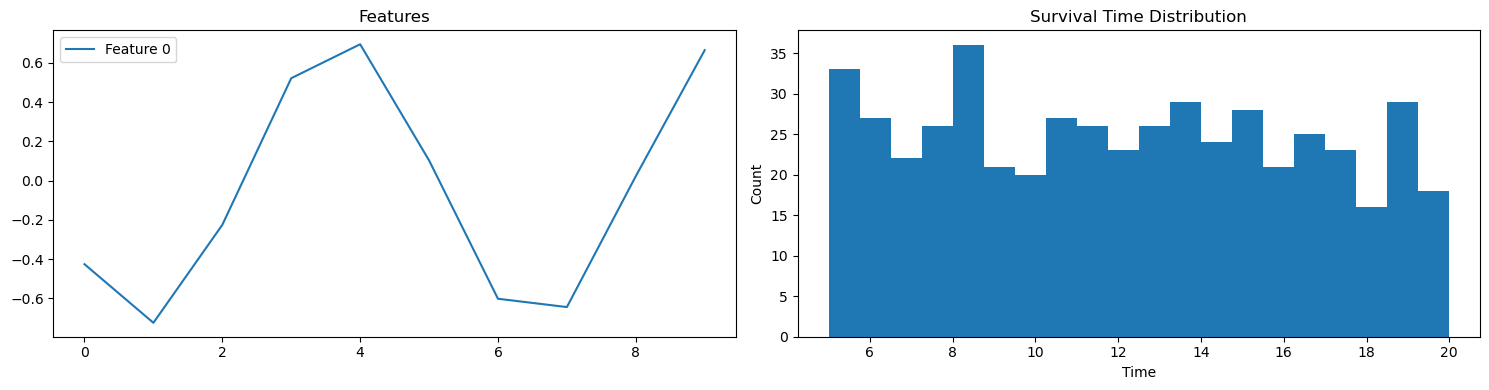

In [24]:
importlib.reload(ukko.data)

#Note: Move this class to ukko.data later
class SineWaveDatasetSurvival(ukko.data.SineWaveDataset):
    def __init__(self, n_samples, weibull_shape=1, weibull_scale=1, seed=42):
        """
        Creates sine wave dataset with survival times based on first feature's frequency, amplidue, or phase
        
        Args:
            n_samples: Number of samples in dataset
            weibull_shape: Shape parameter (k) for Weibull distribution
            weibull_scale: Scale parameter (lambda) for Weibull distribution
            seed: Random seed
        """
        # Init parent class with fixed parameters
        super().__init__(
            n_samples=n_samples,
            n_features=1,
            sequence_length=10,
            prediction_length=1,
            base_freq=0.1,
            noise_level=0.0,
            seed=seed
        )
        
        # Generate Weibull distributed survival times based on first feature frequency
        np.random.seed(seed)
        base_times = np.random.weibull(weibull_shape, n_samples) * weibull_scale
        
        # Scale times based on first feature's frequency. 
        # Note:
        #   - 1-p Weibull distribution is obtained: X = (-ln(U))^(1/k), where U is uniform [0,1] and k is the shape parameter.
        #   - 2-p Weibull inlcuding scale lambda is then: X = lambda * (-ln(U))^(1/k)
        freq_0 = np.array(self.f1f)  # Get frequencies of first feature, each smaple should havea a different frequency, but does not.
        A_samples = np.array(self.f1A) 
        #self.survival_times = np.multiply(base_times, A_samples)
        #self.survival_times = np.multiply(base_times, 2+self.groundtruth[:,0,1].numpy())
        #self.survival_times = 2+self.groundtruth[:,0,1].numpy()
        # make survival times deterministic:
        self.survival_times = 10*A_samples
        print(A_samples)
        
        # Generate random censoring
        # self.censoring = np.random.binomial(1, 0.3, n_samples)  # 30% censoring
        # Generate censoring (30% censored)
        self.events = np.random.binomial(1, 0.7, n_samples)

    def __getitem__(self, idx):
        x, _ = super().__getitem__(idx)
        event = torch.tensor(self.events[idx]).bool()
        time = torch.tensor(self.survival_times[idx]).float()
        return x, (event, time)

# Example usage:
if __name__ == "__main__":
    # Create dataset
    dataset = SineWaveDatasetSurvival(
        n_samples=500,
        weibull_shape=5.0,
        weibull_scale=10.0
    )
    
    # Get first sample
    x, (censoring, time) = dataset[0]
    
    # Plot example
    fig = plt.figure(figsize=(15, 4))
    
    # Plot features
    plt.subplot(121)
    for f in range(dataset.n_features):
        plt.plot(x[f], label=f'Feature {f}')
    plt.title('Features')
    plt.legend()
    
    # Plot survival time distribution
    plt.subplot(122)
    plt.hist(dataset.survival_times, bins=20)
    plt.title('Survival Time Distribution')
    plt.xlabel('Time')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

In [16]:
# Create artifical datasets for testing
train_dataset = SineWaveDatasetSurvival(n_samples=500, seed=42)
val_dataset = SineWaveDatasetSurvival(n_samples=500, seed=43)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the data
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Check first batch
x, (event, time) = next(iter(train_loader))
print("\nFirst batch shapes:")
print(f"Features shape: {x.shape}")
print(f"Events shape: {event.shape}")
print(f"Times shape: {time.shape}")

Training samples: 500
Validation samples: 500

First batch shapes:
Features shape: torch.Size([32, 1, 10])
Events shape: torch.Size([32])
Times shape: torch.Size([32])


In [15]:
train_dataset.groundtruth[0,0,:]

tensor([-0.4264, -0.7254, -0.2259,  0.5223,  0.6955,  0.1032, -0.6027, -0.6452,
         0.0226,  0.6655,  0.5759])

## Section 1: Classical loghazard model

### 1.1 Define model

In [46]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    #torch.nn.Linear(num_features, 32),
    #torch.nn.ReLU(),
    #torch.nn.Dropout(),
    #torch.nn.Linear(32, 64),
    #torch.nn.ReLU(),
    #torch.nn.Dropout(),
    torch.nn.Linear(num_features, 1),  # Estimating log hazards for Cox models
)
cox_model

Sequential(
  (0): BatchNorm1d(270, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=270, out_features=1, bias=True)
)

### 1.2 Train model

In [16]:
import warnings

warnings.filterwarnings("ignore")

In [47]:
cox_model = torch.nn.Sequential(
    torch.nn.BatchNorm1d(num_features),  # Batch normalization
    torch.nn.Linear(num_features, 1),  # Estimating log hazards for Cox models
)
# Disable fused/foreach to avoid platform-specific ImportErrors (common on CPU/Windows)
optimizer = torch.optim.Adam(
    cox_model.parameters(),
    lr=LEARNING_RATE,
    foreach=False,     # PyTorch 2.x: avoids foreach fast path issues
    fused=False        # explicitly disable fused Adam
)


In [48]:
LEARNING_RATE = 1e-3
EPOCHS = 100

from torchsurv.loss.cox import neg_partial_log_likelihood
import copy

torch.manual_seed(42)
# Init optimizer for Cox
optimizer = torch.optim.Adam(cox_model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

warnings.filterwarnings("ignore")

# training loop
best_cox_model = None
best_val_loss = float('inf')
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    cox_model.train() 
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        optimizer.zero_grad()
        log_hz = cox_model(x)  # shape = (16, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}")

    # Reccord loss on train and test sets
    train_losses.append(epoch_loss)
    cox_model.eval()
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        epoch_val_loss = neg_partial_log_likelihood(cox_model(x), event, time, reduction="mean")
        val_losses.append(
          epoch_val_loss
        )

    if not best_cox_model or epoch_val_loss < best_val_loss:
        print("New best model found. ")
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}. Validation loss: {epoch_val_loss:0.2f}")
        best_val_loss = epoch_val_loss #.detach().cpu().numpy()
        best_cox_model = copy.deepcopy(cox_model)
        print("---")

    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch: {epoch:03}, Training loss: {epoch_loss:0.2f}. Validation loss: {epoch_val_loss:0.2f}")

    epoch_loss /= i + 1
    

warnings.filterwarnings("default")

Epoch: 000, Training loss: 8.00
New best model found. 
Epoch: 000, Training loss: 8.00. Validation loss: 7.24
---
Epoch: 000, Training loss: 8.00. Validation loss: 7.24
New best model found. 
Epoch: 001, Training loss: 7.98. Validation loss: 6.55
---
New best model found. 
Epoch: 002, Training loss: 7.95. Validation loss: 6.29
---
New best model found. 
Epoch: 003, Training loss: 7.93. Validation loss: 6.15
---
New best model found. 
Epoch: 004, Training loss: 7.90. Validation loss: 6.07
---
New best model found. 
Epoch: 005, Training loss: 7.88. Validation loss: 6.01
---
New best model found. 
Epoch: 006, Training loss: 7.86. Validation loss: 5.97
---
New best model found. 
Epoch: 007, Training loss: 7.84. Validation loss: 5.94
---
New best model found. 
Epoch: 008, Training loss: 7.82. Validation loss: 5.91
---
New best model found. 
Epoch: 009, Training loss: 7.80. Validation loss: 5.89
---
Epoch: 010, Training loss: 7.78
New best model found. 
Epoch: 010, Training loss: 7.78. Valid

In [57]:

import torch
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title: str = "Cox"):
    """
    Plot normalized training/validation losses and return (fig, ax).

    Args:
        train_losses: Iterable of scalars or 0-D tensors (list[float] or list[torch.Tensor]).
        val_losses:   Iterable of scalars or 0-D tensors.
        title:        Plot title.

    Returns:
        (fig, ax): matplotlib Figure and Axes.
    """
    # Convert to 1D CPU tensors
    def to_1d_tensor(seq):
        if isinstance(seq, torch.Tensor):
            t = seq
            # If it's a scalar history in a 1D tensor, keep it; otherwise ensure 1D
            if t.ndim == 0:
                t = t.unsqueeze(0)
        else:
            # list/tuple of floats or tensors
            t = torch.tensor([float(x.detach().cpu().item()) if isinstance(x, torch.Tensor) else float(x)
                              for x in seq], dtype=torch.float32)
        return t.detach().cpu().flatten()

    tr = to_1d_tensor(train_losses)
    vl = to_1d_tensor(val_losses)

    # Guard against empty inputs
    if tr.numel() == 0 or vl.numel() == 0:
        raise ValueError("train_losses and val_losses must be non-empty.")

    # Normalize by the first element of each series
    tr_norm = tr / tr[0]
    vl_norm = vl / vl[0]

    # Create figure/axes and plot
    fig, ax = plt.subplots(figsize=(7, 4.5))
    ax.plot(tr_norm.numpy(), label="training")
    ax.plot(vl_norm.numpy(), label="validation")
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Normalized loss")
    ax.set_title(title)
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()

    return fig, ax

48


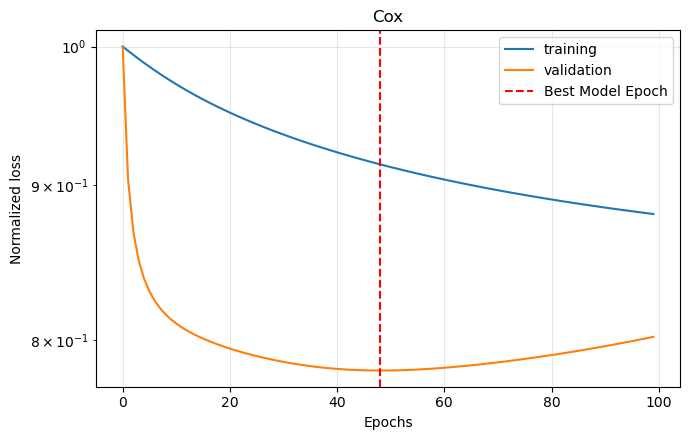

In [58]:
plot_losses(train_losses, val_losses, "Cox")
# plot vertical line at best model epoch
best_epoch = val_losses.index(min(val_losses))
print(best_epoch)
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model Epoch')
plt.legend()

In [22]:
dataloader_test.dataset

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<Figure size 640x480 with 0 Axes>

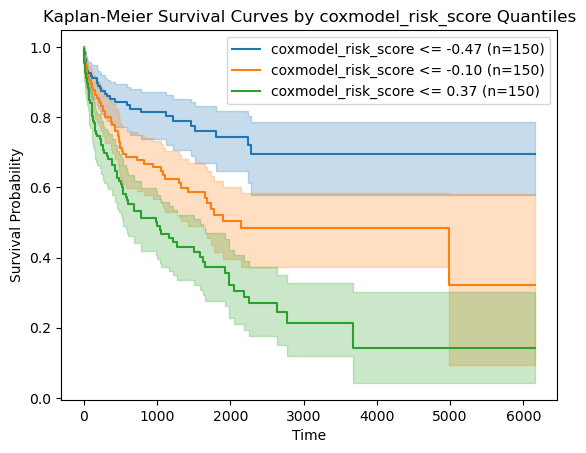

<Figure size 640x480 with 0 Axes>

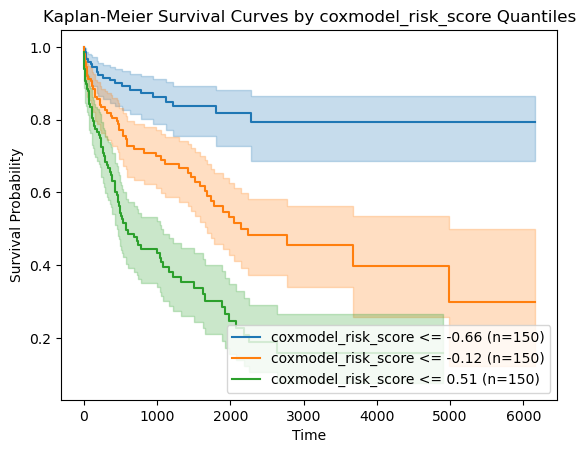

<Figure size 640x480 with 0 Axes>

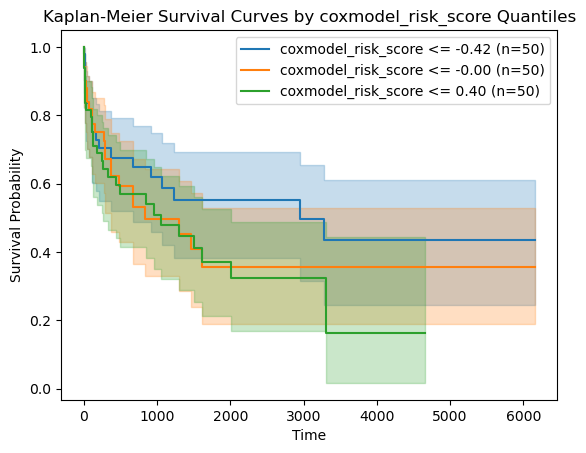

<Figure size 640x480 with 0 Axes>

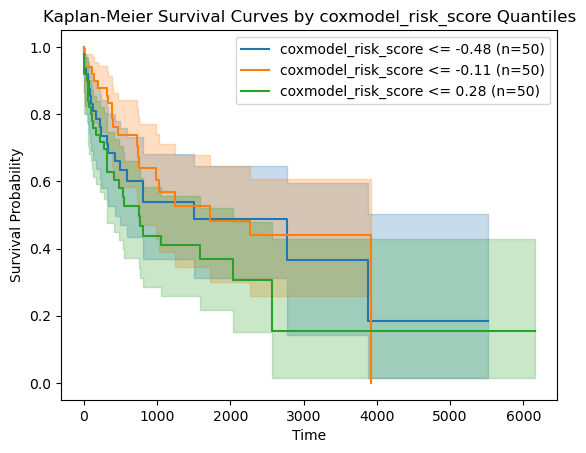

In [62]:
def plot_km_model_lh(model, dataloader, duration_col='OSS_days', event_col='OSS_status'):
    x = dataloader.dataset.getx()
    df_with_risk = dataloader.dataset.df.copy()
    risk_scores = model(x).detach().cpu().numpy()
    print(type(risk_scores))
    df_with_risk[f'coxmodel_risk_score'] = risk_scores
    quantile_values = plot_km_by_quantiles(df_with_risk, f'coxmodel_risk_score', duration_col, event_col, )
    return(df_with_risk, quantile_values)

df_train_with_risk_lh, quantiles_train_lh = plot_km_model_lh(best_cox_model, dataloader_train)
df_train_with_risk_lh, quantiles_train_lh = plot_km_model_lh(cox_model, dataloader_train)
df_test_with_risk_lh, quantiles_test_lh = plot_km_model_lh(best_cox_model, dataloader_val)
df_test_with_risk_lh, quantiles_test_lh = plot_km_model_lh(best_cox_model, dataloader_test)

## Section 2: ukko

### 2.1 Prepare data

In [26]:
importlib.reload(ukko)
importlib.reload(ukko.utils)


<module 'ukko.utils' from 'C:\\Users\\ericf\\Github\\ukko\\src\\ukko\\utils.py'>

In [27]:
## Test:

# Convert AML data to multiindex df
df_x, data_3d = ukko.utils.convert_to_3d_df(df_train.iloc[:,3:].fillna(-1))
df_y = df_train.iloc[:,:3]
#display(df_x)
#display(df_y)

In [28]:
data_3d.shape

(600, 10, 27)

In [33]:
df_xy

,person_id,OSS_days,OSS_status,"('Basophils/100 leukocytes in Blood', -5.0)","('Basophils/100 leukocytes in Blood', -4.0)","('Basophils/100 leukocytes in Blood', -3.0)","('Basophils/100 leukocytes in Blood', -2.0)","('Basophils/100 leukocytes in Blood', -1.0)","('Basophils/100 leukocytes in Blood', 0.0)","('Basophils/100 leukocytes in Blood', 1.0)",...,"('Platelets [#/volume] in Blood', 12.0)","('Platelets [#/volume] in Blood', 13.0)","('Platelets [#/volume] in Blood', 14.0)","('Platelets [#/volume] in Blood', 15.0)","('Platelets [#/volume] in Blood', 16.0)","('Platelets [#/volume] in Blood', 17.0)","('Platelets [#/volume] in Blood', 18.0)","('Platelets [#/volume] in Blood', 19.0)","('Platelets [#/volume] in Blood', 20.0)","('Platelets [#/volume] in Blood', 21.0)"
0,0,1101.0,1,NaN,NaN,NaN,NaN,NaN,0.850735,NaN,...,35.267531,21.842999,26.972079,6.470798,25.946376,35.851646,NaN,NaN,NaN,NaN
1,1,532.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,17.644103,5.856022,33.222468,30.042670,10.961655,16.626338,14.611647,6.030153,27.483864,NaN
2,2,985.0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.9,...,33.075386,19.972356,NaN,10.159840,7.403816,32.169956,13.245301,18.461631,NaN,4.782206
3,3,90.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.108278,NaN,10.593051,NaN,2.842802,11.054564,NaN,23.594939,27.795295,NaN
4,4,1885.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.111444,8.762440,22.310250,25.011994,18.616336,8.396031,11.796703,1.913356,0.251289,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,1835.0,0,NaN,NaN,NaN,NaN,NaN,0.365545,NaN,...,32.470881,39.852095,45.119058,NaN,19.426973,NaN,15.334406,43.252142,30.149195,NaN
996,996,941.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.535567,32.166004,NaN,37.804129,NaN,40.128945,18.025300,NaN,50.305928,51.343236
997,997,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.970071,NaN,NaN,5.812085,51.490996,37.736588,20.504332,31.987580,22.532788,NaN
998,998,77.0,0,NaN,NaN,NaN,NaN,NaN,0.714543,NaN,...,30.374466,NaN,10.356835,NaN,9.787053,NaN,50.671958,45.541768,NaN,NaN


In [ ]:
# Donwsample timepoints - Illustration
# See ukko.utils.downsample_timepoints

importlib.reload(ukko.utils)

# Example usage:
arr = np.array([[np.nan, 2, np.nan, np.nan, 2, 4]])
arr = arr.reshape(1, 1, 6)
print(arr)
print(ukko.utils.downsample_timepoints(arr, rate=2))  # Output: [[[2. nan 3.]]]

df_x, data_3d = ukko.utils.convert_to_3d_df(df_xy.iloc[:,3:])
arr = data_3d[:2,:3,5:10]
with np.printoptions(linewidth=150):
    print("Original array:")
    print(arr)
    print("Downsampled array, 2:")
    print(ukko.utils.downsample_timepoints(arr, rate=2))
    print("Downsampled array, 3:")
    print(ukko.utils.downsample_timepoints(arr, rate=3))
      

[[[nan  2. nan nan  2.  4.]]]
[[[ 2. nan  3.]]]
Original array:
[[[ 0.85073525         nan         nan         nan         nan]
  [19.80517335 20.9                nan         nan         nan]
  [        nan         nan  1.          1.5         2.        ]]

 [[        nan         nan  0.8         0.6                nan]
  [10.2500364  11.9                nan         nan         nan]
  [        nan  0.3         2.                 nan         nan]]]
Downsampled array, 2:
[[[ 0.85073525         nan         nan]
  [20.35258667         nan         nan]
  [        nan  1.25        2.        ]]

 [[        nan  0.7                nan]
  [11.0750182          nan         nan]
  [ 0.3         2.                 nan]]]
Downsampled array, 3:
[[[ 0.85073525         nan]
  [20.35258667         nan]
  [ 1.          1.75      ]]

 [[ 0.8         0.6       ]
  [11.0750182          nan]
  [ 1.15               nan]]]


In [30]:
idx = [0, 1, 3]
torch.tensor(data_3d[idx,:,:]).shape

torch.Size([3, 10, 27])

In [31]:
class ukkosurv_dataset(Dataset):
    """ "Custom dataset for ukko-torcsurv use in df format"""

    # defining values in the constructor
    def __init__(self, df: pd.DataFrame):
        #self.df = df
        df_x, data_3d = ukko.utils.convert_to_3d_df(df.iloc[:,3:].fillna(-1))
        df_y = df_train.iloc[:,:3]
        
        self.df_y = df_y        # Dataframe with survival data, e.g. OSS_status, OSS_days
        self.data_3d = data_3d  # numpy array with 3D feature data: patients, features, time 


    # Getting data size/length
    def __len__(self):
        return len(self.data_3d)

    # Getting the data samples
    def __getitem__(self, idx):
        y = self.df_y.iloc[idx,:]
        # Targets
        event = torch.tensor(y["OSS_status"]).bool()
        time = torch.tensor(y["OSS_days"]).float()
        # Predictors
        x = torch.tensor(self.data_3d[idx,:,:]).float()
        return x, (event, time)

In [67]:
# Dataloader
BATCH_SIZE = 600
dataloader_train = DataLoader(
    ukkosurv_dataset(df_train), batch_size=BATCH_SIZE, shuffle=True
)
dataloader_val = DataLoader(
    ukkosurv_dataset(df_val), batch_size=len(df_val), shuffle=False
)
dataloader_test = DataLoader(
    ukkosurv_dataset(df_test), batch_size=len(df_test), shuffle=False
)

In [20]:
help(dataloader_train)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  DataLoader(dataset: torch.utils.data.dataset.Dataset[+_T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~_T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '', in_order: bool = True)
 |  
 |  Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with 

In [68]:
# Sanity check
x, (event, time) = next(iter(dataloader_train))
num_features, num_timepoints = x.size(1), x.size(2)

print(f"x (shape)      = {x.shape}")
print(f"num_features   = {num_features}")
print(f"num_timepoints = {num_timepoints}")
print(f"event          = {event.shape}")
print(f"time           = {time.shape}")

x (shape)      = torch.Size([600, 10, 27])
num_features   = 10
num_timepoints = 27
event          = torch.Size([600])
time           = torch.Size([600])


### 2.1 Artifical dataset for testing

In [242]:
# Create artifical datasets for testing
train_dataset = SineWaveDatasetSurvival(n_samples=500, seed=42)
val_dataset = SineWaveDatasetSurvival(n_samples=500, seed=43)

# Asing paramters for model accordingly:
num_features   = train_dataset.n_features
num_timepoints = train_dataset.sequence_length

# Create dataloaders
batch_size = 500
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify the data
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# Check first batch
x, (event, time) = next(iter(dataloader_train))
print("\nFirst batch shapes:")
print(f"Features shape: {x.shape}")
print(f"Events shape: {event.shape}")
print(f"Times shape: {time.shape}")

Training samples: 500
Validation samples: 500

First batch shapes:
Features shape: torch.Size([500, 1, 10])
Events shape: torch.Size([500])
Times shape: torch.Size([500])


21

### 2.2 Define model

In [261]:
importlib.reload(ukko.core)

# Initialize model
# DualAttentionRegressor1(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1, n_modules=1)
model = ukko.core.DualAttentionRegressor1(
    n_features=num_features,
    time_steps=num_timepoints,
    d_model=16,
    n_heads=4,
    dropout=0.2,
    n_modules=2
)
model

DualAttentionRegressor1(
  (modules_list): ModuleList(
    (0-1): 2 x DualAttentionModule(
      (input_projection): Linear(in_features=1, out_features=16, bias=True)
      (pos_encoder): PositionalEncoding()
      (feature_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feature_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (feature_ff_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (time_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_fea

In [262]:
# Sanity check:

def sanity_check(model, dataloader):
    """
    Perform basic model sanity checks
    """
    # Get a single batch
    batch, (event, time) = next(iter(dataloader))
    
    print("Input shapes:")
    print(f"Batch: {batch.shape}")
    print(f"Event: {event.shape}")
    print(f"Time: {time.shape}")
    
    # Run forward pass
    try:
        predictions, feat_attn, time_attn = model(batch)
        print("\nOutput shapes:")
        print(f"Predictions: {predictions.shape}")
        print(f"Feature attention: {feat_attn.shape}")
        print(f"Time attention: {time_attn.shape}")
        
        print("\nValue ranges:")
        print(f"Predictions min/max: {predictions.min():.3f}/{predictions.max():.3f}")
        print(f"Feature attention min/max: {feat_attn.min():.3f}/{feat_attn.max():.3f}")
        print(f"Time attention min/max: {time_attn.min():.3f}/{time_attn.max():.3f}")
        
        return True
    except Exception as e:
        print(f"Error during forward pass: {str(e)}")
        return False

# Run sanity check
success = sanity_check(model, dataloader_train)

Input shapes:
Batch: torch.Size([500, 1, 10])
Event: torch.Size([500])
Time: torch.Size([500])

Output shapes:
Predictions: torch.Size([500])
Feature attention: torch.Size([5000, 4, 1, 1])
Time attention: torch.Size([500, 4, 10, 10])

Value ranges:
Predictions min/max: 0.208/0.393
Feature attention min/max: 0.000/1.250
Time attention min/max: 0.000/0.428


### 2.3 Model training

In [263]:
def analyze_model_parameters(model):
    """Analyze model parameters and their shapes"""
    total_params = 0
    print("Model Parameter Analysis:")
    print("-" * 80)
    print(f"{'Layer':<50} {'Shape':<20} {'Parameters':<10}")
    print("-" * 80)
    
    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params
        print(f"{name:<50} {str(list(param.shape)):<20} {num_params:<10,d}")
    
    print("-" * 80)
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Run the analysis
analyze_model_parameters(model)

Model Parameter Analysis:
--------------------------------------------------------------------------------
Layer                                              Shape                Parameters
--------------------------------------------------------------------------------
modules_list.0.input_projection.weight             [16, 1]              16        
modules_list.0.input_projection.bias               [16]                 16        
modules_list.0.feature_attention.W_q.weight        [16, 16]             256       
modules_list.0.feature_attention.W_q.bias          [16]                 16        
modules_list.0.feature_attention.W_k.weight        [16, 16]             256       
modules_list.0.feature_attention.W_k.bias          [16]                 16        
modules_list.0.feature_attention.W_v.weight        [16, 16]             256       
modules_list.0.feature_attention.W_v.bias          [16]                 16        
modules_list.0.feature_attention.W_o.weight        [16, 16]      

In [264]:
torch.manual_seed(42)

EPOCHS = 50
LEARNING_RATE = 1e-2

# Init optimizer for Cox
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# Get device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        x.to(device)
        optimizer.zero_grad()
        log_hz, feature_weights, time_weights = model(x)  # shape = (batchsize, 1)
        loss = neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        log_hz, feature_weights, time_weights = model(x)
        val_losses.append(
            neg_partial_log_likelihood(log_hz, event, time, reduction="mean")
        )

    # Display progress
    #if epoch % (EPOCHS // 10) == 0:
    print(f"Epoch: {epoch:03}, Training loss: {train_losses[-1]:0.2f}, Validation loss: {val_losses[-1]:0.2f}")


Epoch: 000, Training loss: 5.20, Validation loss: 5.20
Epoch: 001, Training loss: 5.20, Validation loss: 5.21
Epoch: 002, Training loss: 5.20, Validation loss: 5.21
Epoch: 003, Training loss: 5.20, Validation loss: 5.20
Epoch: 004, Training loss: 5.19, Validation loss: 5.18
Epoch: 005, Training loss: 5.17, Validation loss: 5.12
Epoch: 006, Training loss: 5.09, Validation loss: 5.02
Epoch: 007, Training loss: 4.99, Validation loss: 5.15
Epoch: 008, Training loss: 5.13, Validation loss: 4.99
Epoch: 009, Training loss: 4.96, Validation loss: 5.09
Epoch: 010, Training loss: 5.06, Validation loss: 5.02
Epoch: 011, Training loss: 4.90, Validation loss: 4.88
Epoch: 012, Training loss: 4.85, Validation loss: 4.90
Epoch: 013, Training loss: 4.88, Validation loss: 4.90
Epoch: 014, Training loss: 4.86, Validation loss: 4.79
Epoch: 015, Training loss: 4.76, Validation loss: 4.80
Epoch: 016, Training loss: 4.77, Validation loss: 4.78
Epoch: 017, Training loss: 4.72, Validation loss: 4.77
Epoch: 018

Cox model performance:
Concordance-index   = 0.9601086378097534
Confidence interval = tensor([0.9480, 0.9722])


Text(0, 0.5, 'Log hazard')

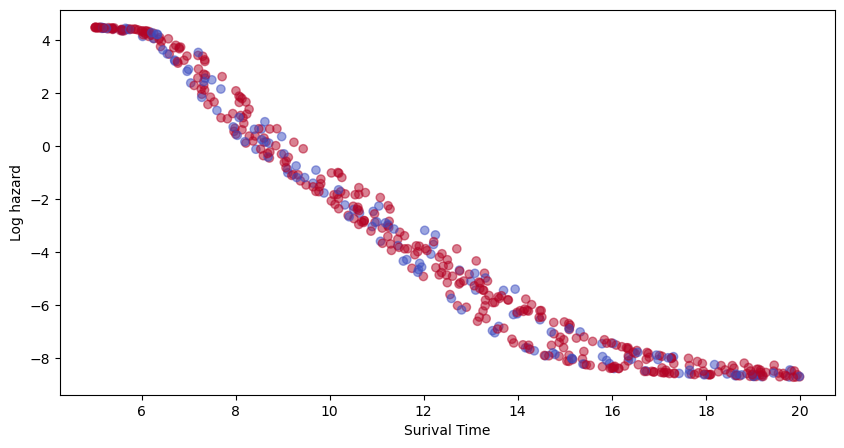

In [265]:
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_train))
    log_hz, feature_weights, time_weights = model(x)  # log hazard of length n

# Concordance index
cox_cindex = ConcordanceIndex()
print("Cox model performance:")
print(f"Concordance-index   = {cox_cindex(log_hz, event, time)}")
print(f"Confidence interval = {cox_cindex.confidence_interval()}")

# plot log hazard vs time
plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_hz, c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Log hazard")



Cox model performance:
Concordance-index   = 0.8750766515731812
Confidence interval = tensor([0.8436, 0.9066])


In [49]:
model.parameters()

<generator object Module.parameters at 0x000001B074C4FCA0>

### 2.4 Weibull-ukko 

This means 2 outputs of model: shape and scale. 

In [277]:
# Create Weibull model

importlib.reload(ukko.core)

# Initialize model
# DualAttentionRegressor1(self, n_features, time_steps, d_model=128, n_heads=8, dropout=0.1, n_modules=1)
model = ukko.core.DualAttentionRegressor1(
    n_features=num_features,
    time_steps=num_timepoints,
    d_model=16,
    n_heads=4,
    dropout=0.2,
    n_modules=2,
    n_outputs=2 # output for log shape and log scale of Weibull
)
model

DualAttentionRegressor1(
  (modules_list): ModuleList(
    (0-1): 2 x DualAttentionModule(
      (input_projection): Linear(in_features=1, out_features=16, bias=True)
      (pos_encoder): PositionalEncoding()
      (feature_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (feature_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (feature_ff_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (time_attention): MultiHeadAttention(
        (W_q): Linear(in_features=16, out_features=16, bias=True)
        (W_k): Linear(in_features=16, out_features=16, bias=True)
        (W_v): Linear(in_features=16, out_features=16, bias=True)
        (W_o): Linear(in_fea

In [299]:
# Training of Weibull model

torch.manual_seed(42)

EPOCHS = 60
LEARNING_RATE = 1e-2

# Init optimizer for Cox
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initiate empty list to store the loss on the train and validation sets
train_losses = []
val_losses = []

# Get device and move model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# training loop
for epoch in range(EPOCHS):
    epoch_loss = torch.tensor(0.0)
    for i, batch in enumerate(dataloader_train):
        x, (event, time) = batch
        x.to(device)
        optimizer.zero_grad()
        log_params, feature_weights, time_weights = model(x)  
        loss = neg_log_likelihood(log_params, event, time, reduction="mean")
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()

    # Reccord loss on train and test sets
    epoch_loss /= i + 1
    train_losses.append(epoch_loss)
    with torch.no_grad():
        x, (event, time) = next(iter(dataloader_val))
        log_params, feature_weights, time_weights = model(x)
        val_losses.append(
            neg_log_likelihood(log_params, event, time, reduction="mean")
        )

    # Display progress
    #if epoch % (EPOCHS // 10) == 0:
    print(f"Epoch: {epoch:03}, Training loss: {train_losses[-1]:0.2f}, Validation loss: {val_losses[-1]:0.2f}")

Epoch: 000, Training loss: 1.72, Validation loss: 13.35
Epoch: 001, Training loss: 10.66, Validation loss: 2.55
Epoch: 002, Training loss: 1.67, Validation loss: 1.97
Epoch: 003, Training loss: 2.07, Validation loss: 2.71
Epoch: 004, Training loss: 3.00, Validation loss: 3.29
Epoch: 005, Training loss: 3.58, Validation loss: 3.47
Epoch: 006, Training loss: 3.78, Validation loss: 3.33
Epoch: 007, Training loss: 3.62, Validation loss: 3.02
Epoch: 008, Training loss: 3.28, Validation loss: 2.68
Epoch: 009, Training loss: 2.92, Validation loss: 2.39
Epoch: 010, Training loss: 2.60, Validation loss: 2.20
Epoch: 011, Training loss: 2.36, Validation loss: 2.19
Epoch: 012, Training loss: 2.29, Validation loss: 2.29
Epoch: 013, Training loss: 2.33, Validation loss: 2.35
Epoch: 014, Training loss: 2.37, Validation loss: 2.32
Epoch: 015, Training loss: 2.32, Validation loss: 2.24
Epoch: 016, Training loss: 2.25, Validation loss: 2.15
Epoch: 017, Training loss: 2.17, Validation loss: 2.07
Epoch: 0

Weibull model performance:
Concordance-index   = 0.835179328918457
Confidence interval = tensor([0.8045, 0.8658])
p-value             = 0.0


Text(0, 0.5, 'Scale parameter (log scale)')

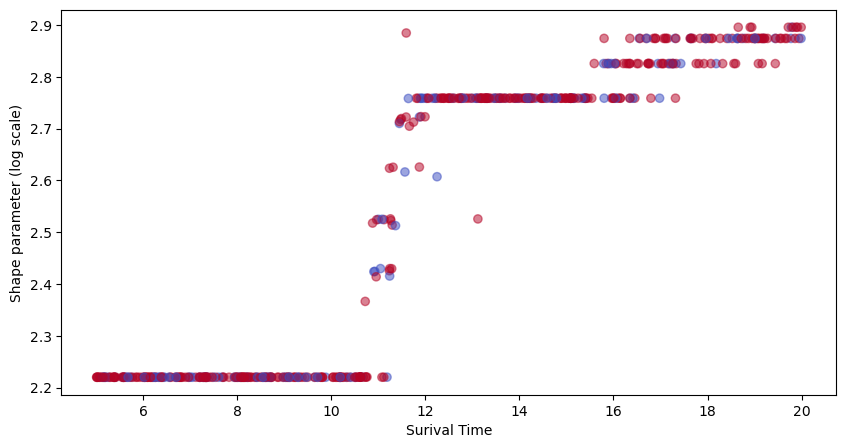

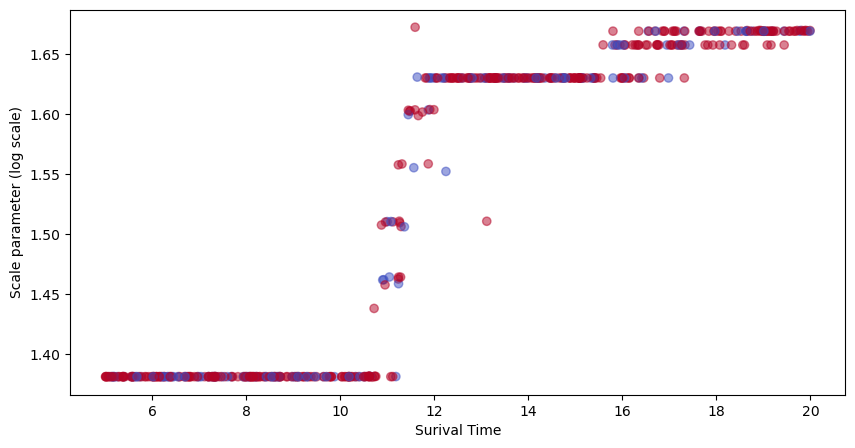

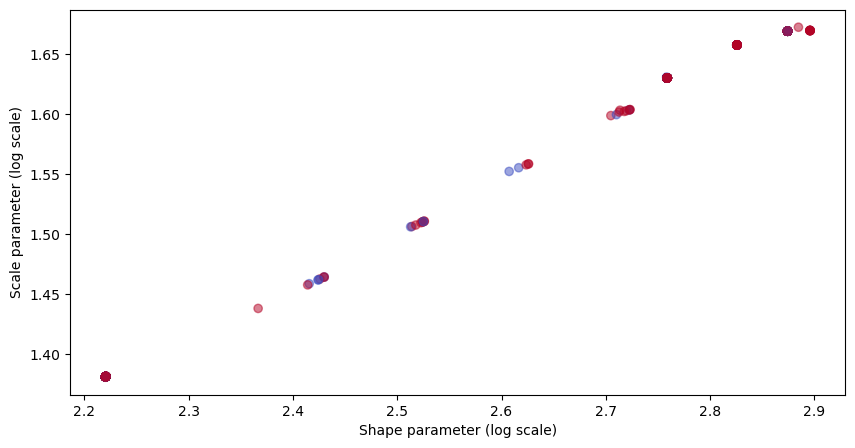

In [300]:
model.eval()
with torch.no_grad():
    # test event and test time of length n
    x, (event, time) = next(iter(dataloader_train))
    log_params, feature_weights, time_weights = model(x)  # log hazard of length n

# Additional step for Weibull:
# Compute the log hazards from weibull log parameters
log_hz = log_hazard(log_params, time)  
# Compute the survival probability from weibull log parameters
surv = survival_function(log_params, time)  

# Concordance index
weibull_cindex = ConcordanceIndex()
print("Weibull model performance:")
print(f"Concordance-index   = {weibull_cindex(log_hz, event, time)}")
print(f"Confidence interval = {weibull_cindex.confidence_interval()}")

# H0: cindex = 0.5, Ha: cindex >0.5
print(f"p-value             = {weibull_cindex.p_value(alternative = 'greater')}")

# plot log hazard vs time
plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_params[:,0], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Shape parameter (log scale)")

plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(time, log_params[:,1], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Surival Time")
plt.ylabel("Scale parameter (log scale)")

plt.figure(figsize=(10, 5))
# change to scatter plot and color by event 
plt.scatter(log_params[:,0], log_params[:,1], c=event, cmap='coolwarm', alpha=0.5)
plt.xlabel("Shape parameter (log scale)")
plt.ylabel("Scale parameter (log scale)")



In [283]:
log_hz.shape

torch.Size([500, 500])

# Honey

In [ ]:

y = [0.0011, 0.0026, 0.0062, 0.0173]
t = [19.5, 20.16, 20.75, 22.5]



In [61]:
def time_str_to_hours(time_str):
    """Convert time string in format 'XhYY' to decimal hours
    
    Args:
        time_str (str): Time in format like '2h13' or '3h45'
    
    Returns:
        float: Decimal hours
    """
    h, m = time_str.split('h')
    return float(h) + float(m)/60

y = np.array([0.0011, 0.0026, 0.0062, 0.0173, 0.0315, 0.34])
h = ['19h31', '20h10', '20h45', '22h25', '23h00', '25h38']

#y = np.array([0.0026, 0.0062, 0.0173, 0.0315])
#h = ['20h10', '20h45', '22h25', '23h00']


# Convert time strings to decimal hours
t = [time_str_to_hours(time) for time in h]
print("Times in decimal hours:", [f"{x:.2f}" for x in t])

Times in decimal hours: ['19.52', '20.17', '20.75', '22.42', '23.00', '25.63']


Time to reach 0.4: 1h 48min


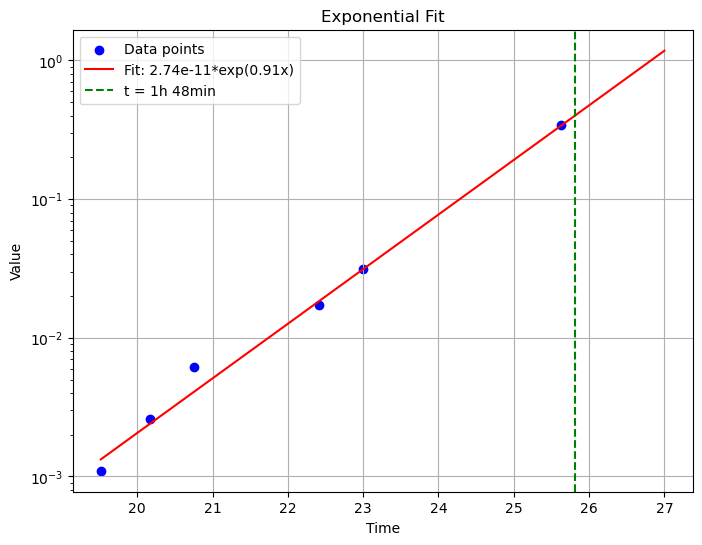

Fitted function: y = 2.74e-11 * exp(0.91 * x)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define exponential function
def exp_func(x, a, b):
    return a * np.exp(b * x)

# Convert lists to numpy arrays
#t = np.array([19.5, 20.16, 20.75, 22.45])
#y = np.array([0.0011, 0.0026, 0.0062, 0.0175])

# Fit exponential function
popt, pcov = curve_fit(exp_func, t, y)
a, b = popt

# Generate points for smooth curve
t_smooth = np.linspace(min(t), 27, 100)
y_fit = exp_func(t_smooth, a, b)

# Find where y reaches 0.4
t_at_04 = np.log(0.4/a)/b

def hours_to_hm(hours):
    h = int(hours)
    m = int((hours - h) * 60)
    return f"{h}h {m}min"

# Add this line after finding t_at_04
time_hm = hours_to_hm(t_at_04 - 24)
print(f"Time to reach 0.4: {time_hm}")

# Create plot
plt.figure(figsize=(8, 6))
plt.scatter(t, y, color='blue', label='Data points')
plt.plot(t_smooth, y_fit, 'r-', label=f'Fit: {a:.2e}*exp({b:.2f}x)')

plt.axvline(x=t_at_04, color='green', linestyle='--', label=f't = {time_hm}')

plt.yscale('log')  

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Exponential Fit')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted function: y = {a:.2e} * exp({b:.2f} * x)")